# Double Poisson Model for Predicting Football Results

## Comparing Match Outcome Predictions Across Two Modelling Strategies

Nov 18 2025, Olena Shevchenko

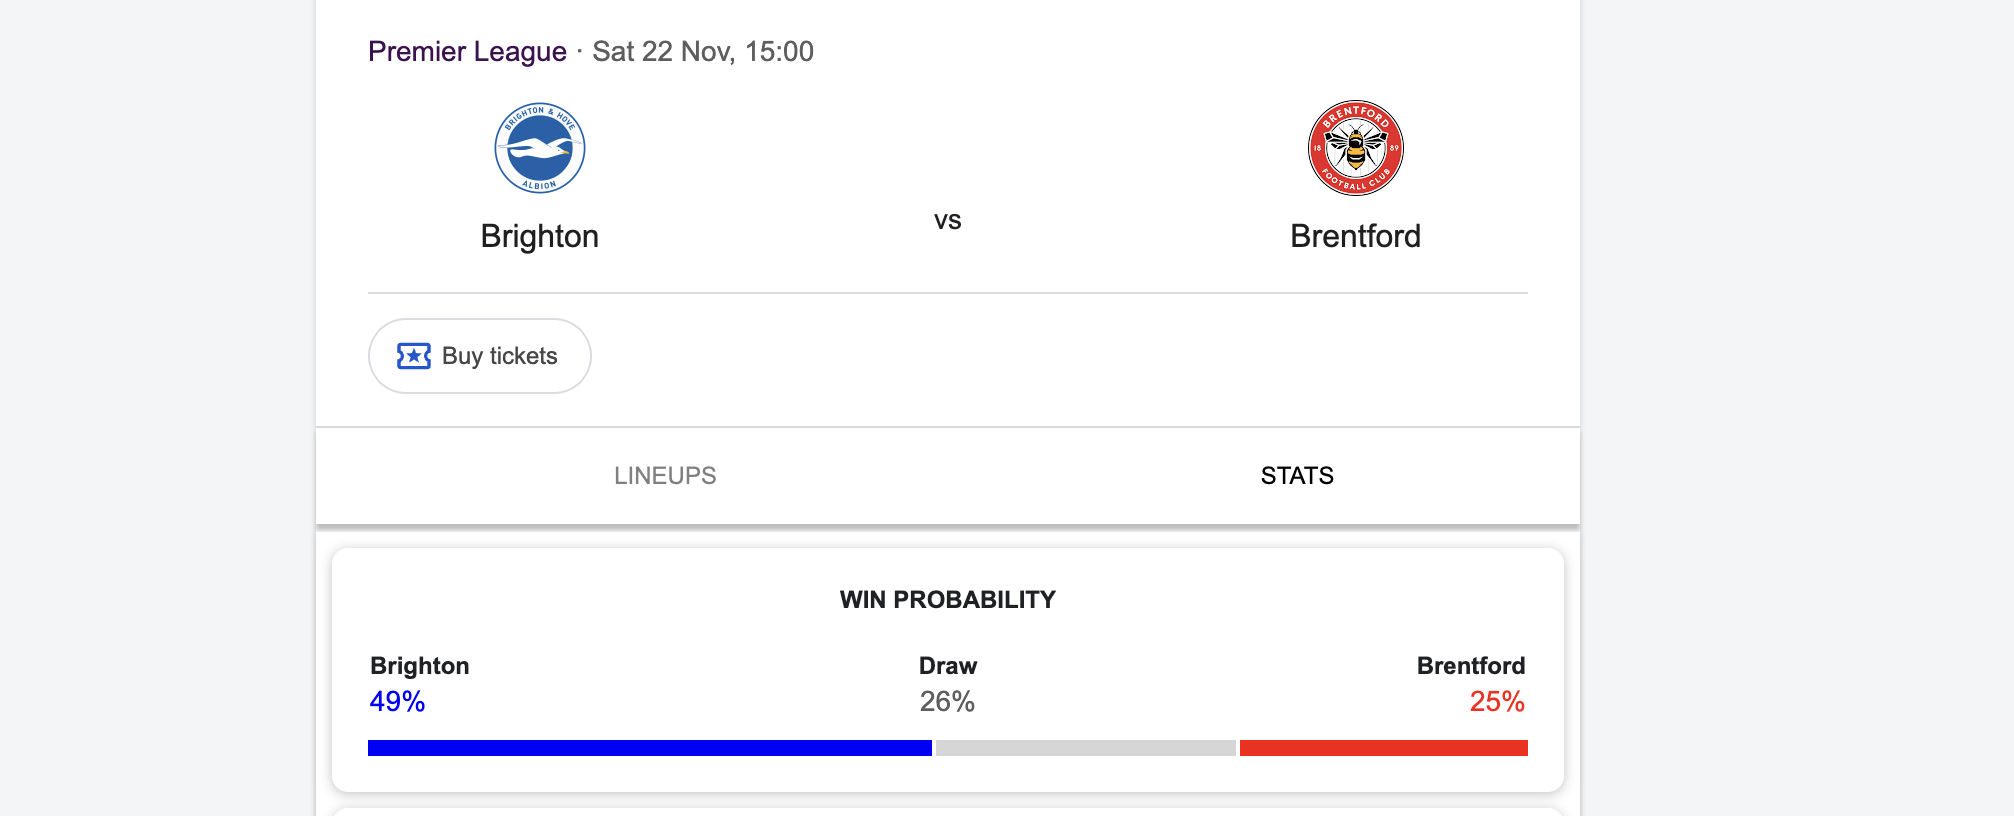

# 1. Introduction

This notebook investigates two variants of the double Poisson framework for football score prediction and applies them to forecast the outcome of an upcoming match between Brighton and Brentford. The analysis compares the approach of Loukas et al., which derives team attacking and defensive strengths from season-level goal averages within a structured log-linear model, with the Penn–Donnelly formulation, which estimates team strengths through maximum-likelihood optimisation over the full distribution of match scorelines. By implementing both methods, estimating their parameters from Premier League data, and evaluating their resulting match probabilities and most likely scorelines, the notebook aims to highlight how different modelling assumptions influence predictive outcomes and to demonstrate practical competence in statistical modelling for football analytics.

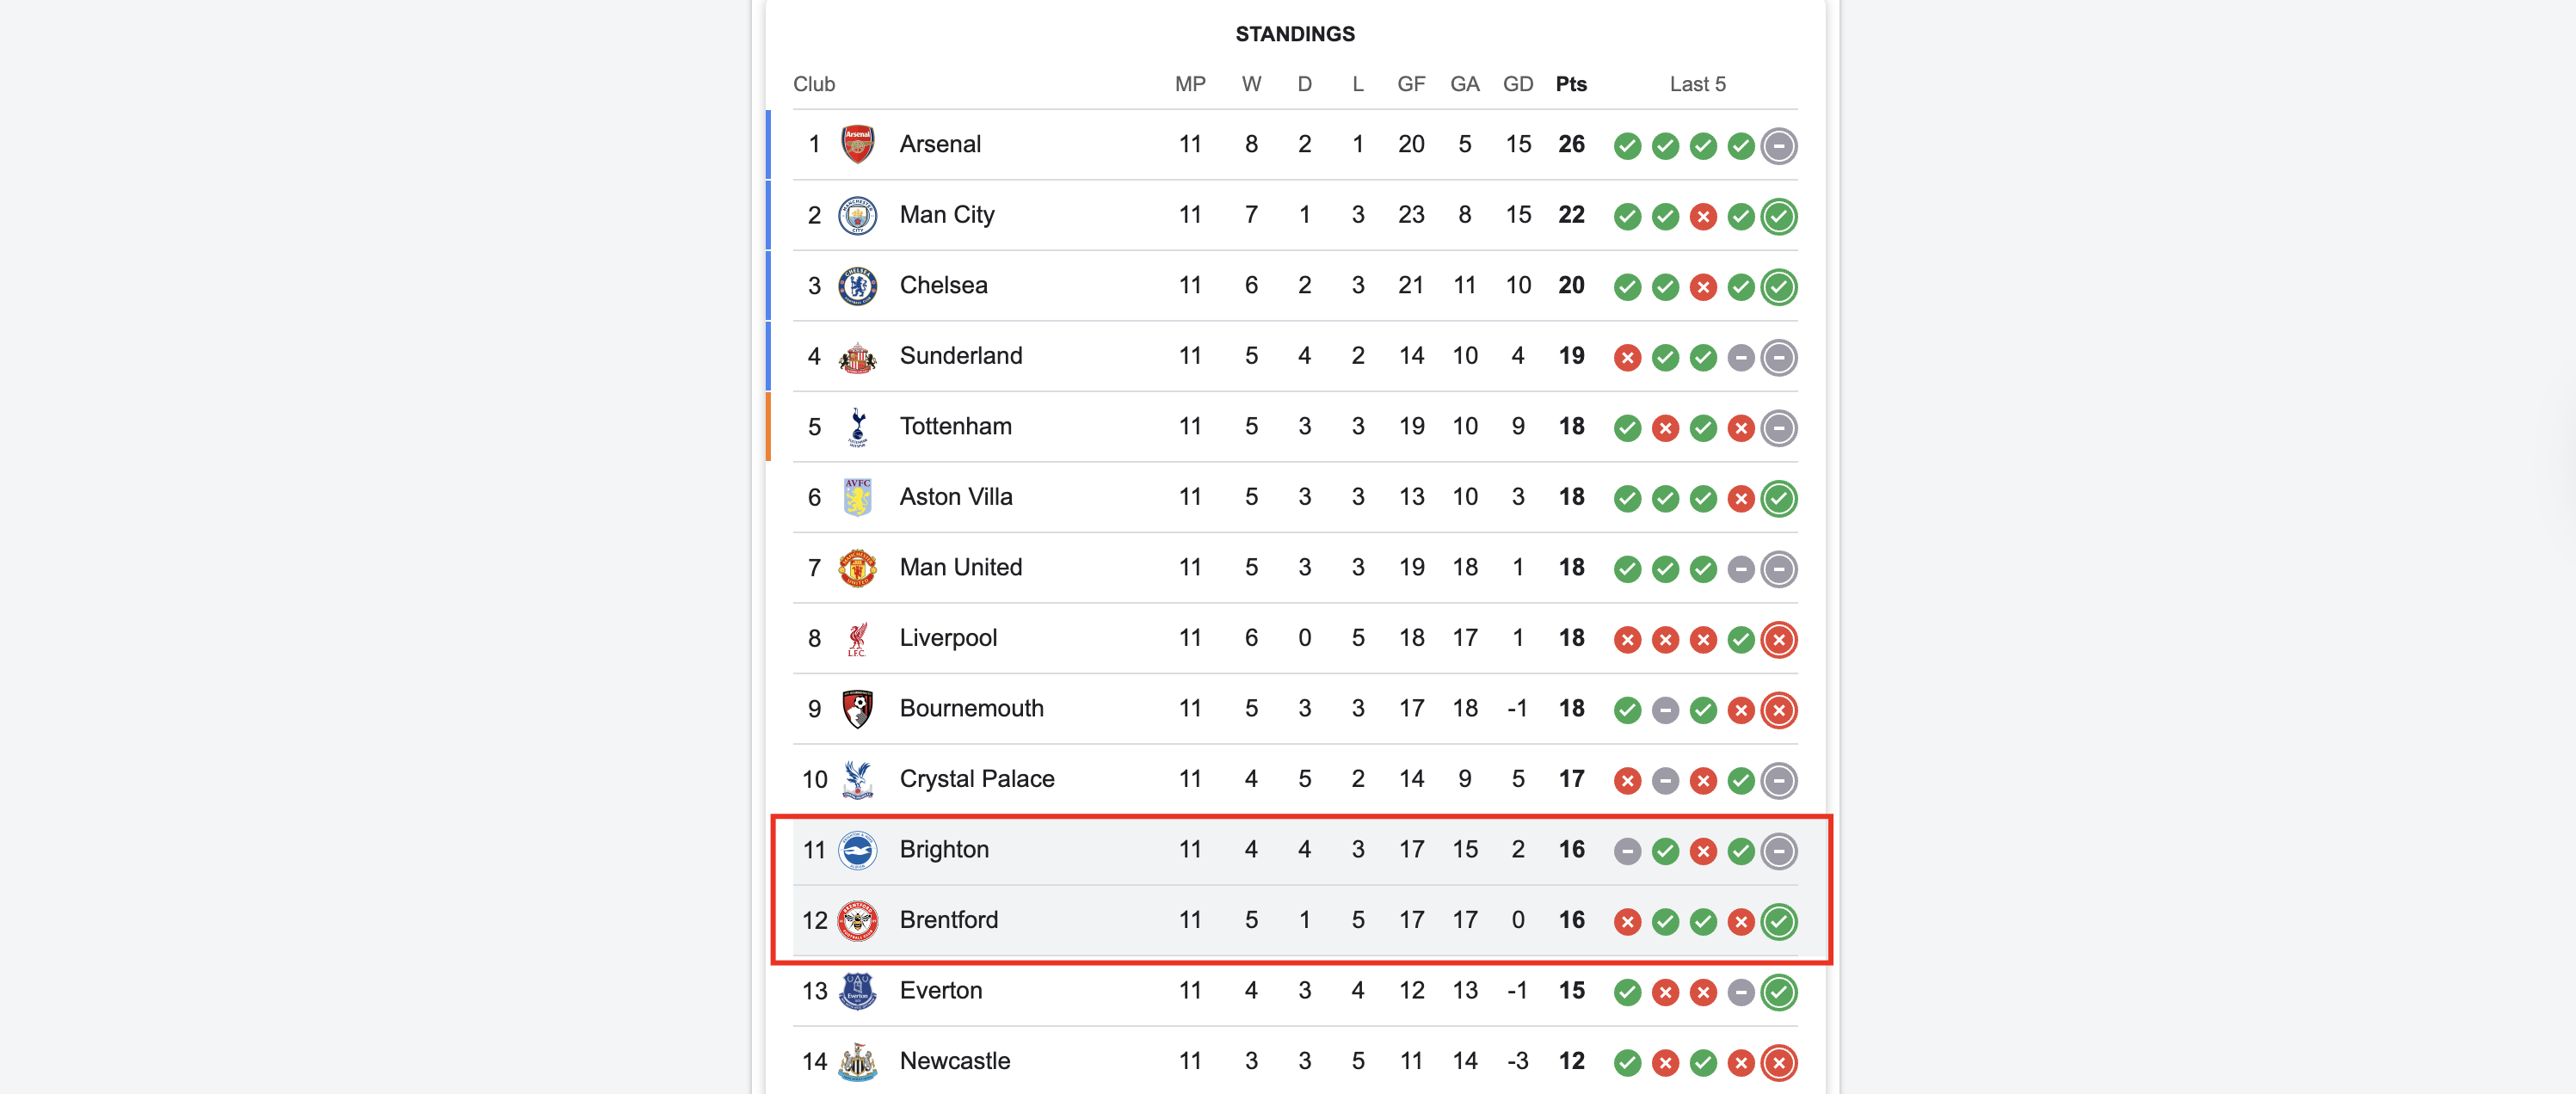

# 2. Data

We need match-level results for at least one full Premier League season, including:

Columns per match:

- Date
- HomeTeam
- AwayTeam
- Full-time home goals (FTHG)
- Full-time away goals (FTAG)

We will use a dataset from Kaggle “[English Premier League & Championship Full Dataset](https://www.kaggle.com/datasets/filippomonte/premier-league-past-3-seasons?utm_source=chatgpt.com)”.

Match records from the 2022-2025 season, including matches that have not occurred yet. I included a link for each match to find additional information on it. The dataset is meant to be used in educational purposes, for programmers to create and test predictive algorithms.


We will start with just PL 2022-23, as in Loukas, and directly compare our parameters.

Then we will extend the dataset with scraped PL scores for the current 2025/2026 season.

# 3. Model

The double Poisson framework is a widely used statistical model for predicting football scorelines by assuming that each team’s goals follow independent Poisson distributions whose means reflect the teams’ underlying attacking and defensive strengths. In the Loukas et al. approach, these strengths are derived from season-level averages such as goals scored and conceded per match, combined with league-wide parameters and an explicit home-advantage term to produce expected goal values for the home and away sides. By contrast, the Penn & Donnelly formulation estimates each team’s attacking strength and defensive vulnerability through maximum-likelihood optimisation over all individual match results, allowing the full distribution of observed scorelines—not just aggregated averages—to inform the parameter estimates. While both methods rely on the same underlying Poisson assumption, Loukas’ model uses summary statistics and a structured regression form, whereas Penn & Donnelly’s formulation infers strengths directly from the likelihood of observed results, leading to a more flexible but symmetric representation of team performance.

[Loukas et al. formulation of The double Poisson model](https://www.mdpi.com/2076-3417/14/16/7230)

Loukas, Konstantinos, Dimitrios Karapiperis, Georgios Feretzakis, and Vassilios S. Verykios. 2024. "Predicting Football Match Results Using a Poisson Regression Model" Applied Sciences 14, no. 16: 7230. https://doi.org/10.3390/app14167230


[Penn & Donnelly formulation of The double Poisson model](https://pmc.ncbi.nlm.nih.gov/articles/PMC9119507/):

Penn MJ, Donnelly CA. Analysis of a double Poisson model for predicting football results in Euro 2020. PLoS One. 2022 May 19;17(5):e0268511. doi: 10.1371/journal.pone.0268511. PMID: 35588428; PMCID: PMC9119507.

Poisson probability mass function:

$$P(k;λ)=\frac{λ^{k}e^{−λ}​}{k!}$$

## 3.1 Core model from the Loukas paper (Premier League 22-23)

### 3.1.1 Double Poisson score model Loukas et al

For a given match with home team H and away team A, goals scored are assumed independent:

$$X_H​∼Poisson(λ_{Home}​),X_A​∼Poisson(λ_{Away}​)$$

The joint probability of a specific scoreline $k-h$ is:

$$P(X_H​=k,X_A​=h)=\frac{λ_{Home}^{k}​e^{−λ_{Home}​}​}{k!}⋅\frac{λ_{Away}^{h}​e^{−λ_{Away}​}​}{h!}$$

Match outcome probabilities are then:

- $P(Home\_win) = \sum_{k>h}P(X_H​=k,X_A​=h)$

- $P(Draw)=\sum_{k=h}P(X_H​=k,X_A​=h)$

- $P(Away\_win) = \sum_{k<h}P(X_H​=k,X_A​=h)$

### 3.1.2 Regression structure for λ (team strengths + home advantage)

Loukas et al. use a log-link Poisson regression:

$$log(λ_{Home}​)=μ+μ_{Home}​+att_{Home}​+def_{Away}$$

$$log(λ_{Away}​)=μ​+att_{Away}​+def_{Home}$$

where:

- μ = log of the average away goals per match across the league

- μ_home = log difference between league average home and away goals

$$μ_{Home}​=log(\overline{G}_{home}​)−log(\overline{G}_{away}​)$$

- att_team = attacking quality of a team

- def_team = defensive quality of a team

They show how to compute these from raw season totals:
1. Compute $\overline{G}_{home}$, $\overline{G}_{away}$ and then

$$μ=log(\overline{G}_{away}), \quad μ_{Home}​=log(\overline{G}_{home}​)−log(\overline{G}_{away}​)$$

2. For each team $t$, compute:
- Avg goals **for** per match: $\overline{GF_{t}}$
- Avg goals **against** per match: $\overline{GA_{t}}$

3. Define:

$$att_t​=log(\overline{GF_{t}})−μ, \quad def_t=log(\overline{GA_{t}})−μ$$

So for **Brighton (home) vs Brentford (away)** our λs become:

$$log(λ_{Brighton​}​)=μ+μ_{Brighton​}​+att_{Brighton​}​+def_{Brentford​}$$

$$log(λ_{Brentford​}​)=μ​+att_{Brentford​}​+def_{Brighton​}$$

In this notebook, we will recompute these values from the raw data and then verify our results against Loukas' paper values as a sanity check.

## 3.2 Penn & Donnelly’s formulation of the Double Poisson score model

Penn & Donnelly formulate a general double Poisson model for tournaments (Euro 2020):
- Expected goals for Team A vs Team B:
$$μ_{A,B}​=O_A​V_B​$$
where $O_A$ is attacking strength and $V_B$ is defensive vulnerability.
- For a match A (home) vs B (away), goals scored:

$$X_A​∼Poisson(O_A​V_B​), \quad X_B​∼Poisson(O_B​V_A​)$$

The estimate $O_A, V_B$ via maximum likelihood, resulting in nonlinear equations (gradient of the log-likelihood = 0) that we can solve numerically (e.g. with scipy.optimize).

# 5. Prediction: Brighton vs Brentford

- Compute expected goals (λ_home, λ_away).
- Build the scoreline probability matrix and 1X2 probabilities.

## 5.1 Calculation for 22-23 season to check compliance with Loukas’ metrics

In [3]:
import pandas as pd
import numpy as np
from itertools import product
from math import factorial
import kagglehub
import requests

In [4]:
# Download latest version
path = kagglehub.dataset_download("filippomonte/premier-league-past-3-seasons")

print("Path to dataset files:", path)

100%|██████████| 35.6k/35.6k [00:00<00:00, 33.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/filippomonte/premier-league-past-3-seasons/versions/1


In [6]:
import os

file_path_list = []
for root, dirs, files in os.walk(path):
    for f in files:
        file_path_list.append(os.path.join(root, f))
        print(os.path.join(root, f))
print(file_path_list)

/root/.cache/kagglehub/datasets/filippomonte/premier-league-past-3-seasons/versions/1/PremierLeagueMatches.csv
['/root/.cache/kagglehub/datasets/filippomonte/premier-league-past-3-seasons/versions/1/PremierLeagueMatches.csv']


In [7]:
raw = pd.read_csv(file_path_list[0])
print(raw.shape)
raw.head()

(1140, 14)


,Matchday,Date,Time,Home Team,homeScore,homeXG,awayScore,awayXG,Away Team,Attendance,Referee,Stadium,Result,*Additional Stats
0,1,2022-08-05,20:00,Crystal Palace,0.0,1.2,2.0,1.0,Arsenal,"25,286",Anthony Taylor,Selhurst Park,A,https://fbref.com//en/matches/e62f6e78/Crystal...
1,1,2022-08-06,12:30,Fulham,2.0,1.2,2.0,1.2,Liverpool,"22,207",Andy Madley,Craven Cottage,D,https://fbref.com//en/matches/6713c1dc/Fulham-...
2,1,2022-08-06,15:00,Tottenham,4.0,1.5,1.0,0.5,Southampton,"61,732",Andre Marriner,Tottenham Hotspur Stadium,H,https://fbref.com//en/matches/09d8a999/Tottenh...
3,1,2022-08-06,15:00,Newcastle Utd,2.0,1.7,0.0,0.3,Nott'ham Forest,"52,245",Simon Hooper,St James' Park,H,https://fbref.com//en/matches/1ac96eb4/Newcast...
4,1,2022-08-06,15:00,Leeds United,2.0,0.8,1.0,1.3,Wolves,"36,347",Robert Jones,Elland Road,H,https://fbref.com//en/matches/82702941/Leeds-U...


In [8]:
matches = (
    raw[["Date", "Home Team", "Away Team", "homeScore", "awayScore"]]
    .rename(columns={"homeScore": "home_goals", "awayScore": "away_goals",
                     "Home Team": "home", "Away Team": "away"})
    .dropna()
)
matches.head(3)

,Date,home,away,home_goals,away_goals
0,2022-08-05,Crystal Palace,Arsenal,0.0,2.0
1,2022-08-06,Fulham,Liverpool,2.0,2.0
2,2022-08-06,Tottenham,Southampton,4.0,1.0


In [10]:
matches['Date'] = pd.to_datetime(matches["Date"])
matches['Date'].iloc[0]

Timestamp('2022-08-05 00:00:00')

In [13]:
print(matches[matches['home'] == 'Brighton']["Date"].max())
print(matches[matches['home'] == 'Brighton']["Date"].min())

2025-03-08 00:00:00
2022-08-13 00:00:00


In [14]:
print(matches[matches['home'] == 'Brentford']["Date"].max())
print(matches[matches['home'] == 'Brentford']["Date"].min())

2025-03-08 00:00:00
2022-08-13 00:00:00


In [19]:
matches["Date"].max()

Timestamp('2025-03-16 00:00:00')

### 5.1.1 Compute league averages and μ, μ_home for the 22-23 season


In [16]:
season22_23_df = matches[(matches['Date'] >= '2022-08-01') & (matches['Date'] < '2023-08-01')].copy()

In [17]:
n_matches = len(season22_23_df)
total_home_goals = season22_23_df["home_goals"].sum()
total_away_goals = season22_23_df["away_goals"].sum()

g_home = total_home_goals / n_matches
g_away = total_away_goals / n_matches

mu = np.log(g_away)                 # log average away goals
mu_home = np.log(g_home) - np.log(g_away)  # home advantage on log scale

mu, mu_home

(np.float64(0.19755580136580253), np.float64(0.2936040278472448))

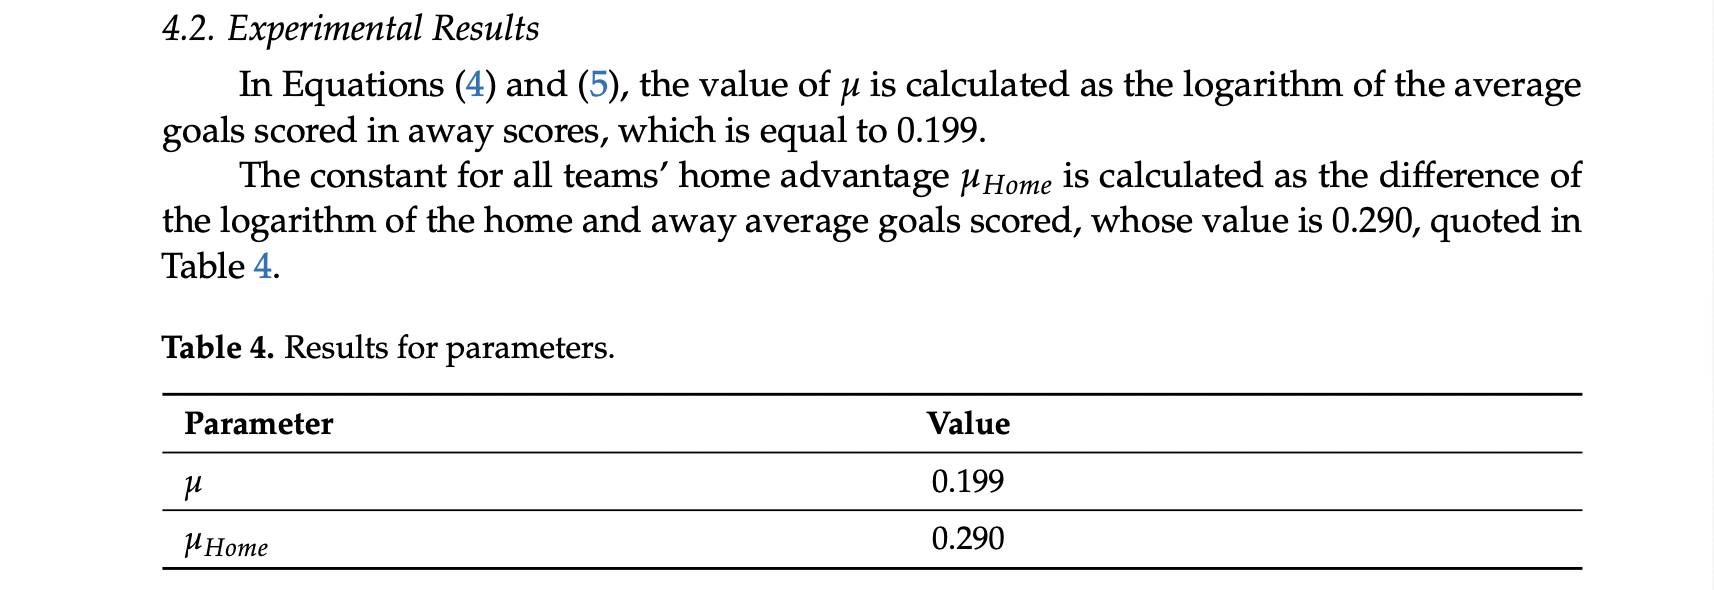

We received values close to Loukas’ μ = 0.199, μ_home = 0.290 for the 22-23 season.

### 5.1.2 Compute team attack & defence parameters the 22-23 season

In [18]:
# aggregate team totals (home + away)
home_stats = season22_23_df.groupby("home")[["home_goals", "away_goals"]].sum()
away_stats = season22_23_df.groupby("away")[["home_goals", "away_goals"]].sum()

team_goals_for = home_stats["home_goals"].add(away_stats["away_goals"], fill_value=0)
team_goals_against = home_stats["away_goals"].add(away_stats["home_goals"], fill_value=0)

team_matches = (
    season22_23_df["home"].value_counts().add(season22_23_df["away"].value_counts(), fill_value=0)
)

avg_gf = team_goals_for / team_matches
avg_ga = team_goals_against / team_matches

att = np.log(avg_gf) - mu
defn = np.log(avg_ga) - mu

team_params = pd.DataFrame({
    "avg_gf": avg_gf,
    "avg_ga": avg_ga,
    "att": att,
    "def": defn
})

team_params.loc[["Brighton", "Brentford"]]

,avg_gf,avg_ga,att,def
home,,,,
Brighton,1.894737,1.394737,0.441524,0.135150
Brentford,1.526316,1.210526,0.225301,-0.006501


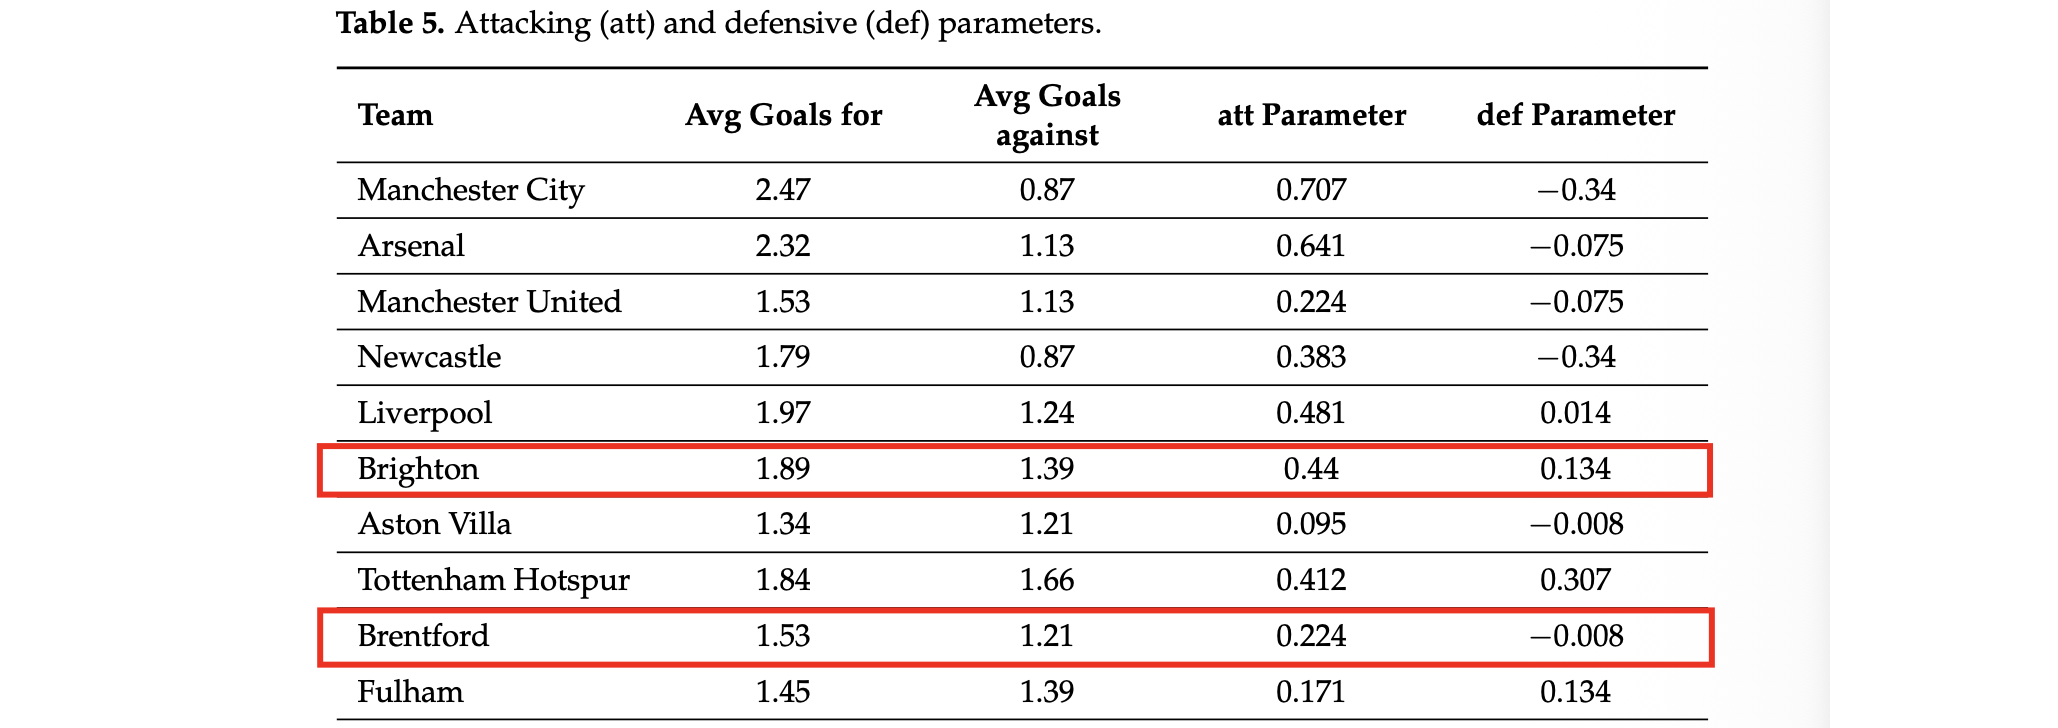

These results are in close agreement with Loukas et al. Table 5 for the 22–23 season.

## 5.2 Prediction: Brighton vs Brentford for Saturday 22nd November 2025

I scraped PL data for the 2025/2026 season.

In [20]:
new_season_df = pd.read_csv('season2025.csv')
print(new_season_df.shape)
new_season_df.head()

(200, 5)


,Date,home,away,home_goals,away_goals
0,2025-04-01,Nott'ham Forest,Manchester Utd,1,0
1,2025-04-01,Wolves,West Ham,1,0
2,2025-04-01,Arsenal,Fulham,2,1
3,2025-04-02,Liverpool,Everton,1,0
4,2025-04-02,Southampton,Crystal Palace,1,1


In [21]:
new_season_df['Date'] = pd.to_datetime(new_season_df["Date"])
new_season_df['Date'].iloc[0]

Timestamp('2025-04-01 00:00:00')

In [22]:
final_df = pd.concat([matches, new_season_df])
final_df.shape

(1249, 5)

### 5.2.1 Compute league averages and μ, μ_home for the 22-ongoing season

In [24]:
n_matches = len(final_df)
total_home_goals = final_df["home_goals"].sum()
total_away_goals = final_df["away_goals"].sum()

g_home = total_home_goals / n_matches
g_away = total_away_goals / n_matches

mu = np.log(g_away)                 # log average away goals
mu_home = np.log(g_home) - np.log(g_away)  # home advantage on log scale

mu, mu_home

(np.float64(0.29942233266088436), np.float64(0.19851028414387295))

### 5.2.2 Compute team attack & defence parameters the 22-ongoing season

In [25]:
# aggregate team totals (home + away)
home_stats = final_df.groupby("home")[["home_goals", "away_goals"]].sum()
away_stats = final_df.groupby("away")[["home_goals", "away_goals"]].sum()

team_goals_for = home_stats["home_goals"].add(away_stats["away_goals"], fill_value=0)
team_goals_against = home_stats["away_goals"].add(away_stats["home_goals"], fill_value=0)

team_matches = (
    final_df["home"].value_counts().add(final_df["away"].value_counts(), fill_value=0)
)

avg_gf = team_goals_for / team_matches
avg_ga = team_goals_against / team_matches

att = np.log(avg_gf) - mu
defn = np.log(avg_ga) - mu

team_params = pd.DataFrame({
    "avg_gf": avg_gf,
    "avg_ga": avg_ga,
    "att": att,
    "def": defn
})

team_params.loc[["Brighton", "Brentford"]]

,avg_gf,avg_ga,att,def
home,,,,
Brighton,1.680,1.512,0.219371,0.114011
Brentford,1.576,1.480,0.155468,0.092620


### 5.2.3 Compute λ for Brighton (home) vs Brentford (away)

In [27]:
def expected_goals(home_team, away_team, team_params, mu, mu_home):
    att_home = team_params.loc[home_team, "att"]
    def_home = team_params.loc[home_team, "def"]
    att_away = team_params.loc[away_team, "att"]
    def_away = team_params.loc[away_team, "def"]

    log_lambda_home = mu + mu_home + att_home + def_away
    log_lambda_away = mu + att_away + def_home

    return np.exp(log_lambda_home), np.exp(log_lambda_away)

lam_home, lam_away = expected_goals("Brighton", "Brentford", team_params, mu, mu_home)
lam_home, lam_away

(np.float64(2.2477367760568465), np.float64(1.7663246813056381))

### 5.2.4 Building scoreline probability matrix and 1X2 probabilities

In [28]:
from math import exp

def poisson_pmf(k, lam):
    return (lam**k) * np.exp(-lam) / factorial(k)

def scoreline_probs(lam_home, lam_away, max_goals=9):
    scores = range(0, max_goals + 1)
    prob_matrix = np.zeros((max_goals+1, max_goals+1))

    for k in scores:      # home goals
        for h in scores:  # away goals
            prob_matrix[k, h] = poisson_pmf(k, lam_home) * poisson_pmf(h, lam_away)
    return prob_matrix

prob_mat = scoreline_probs(lam_home, lam_away, max_goals=9)

home_win_prob = np.tril(prob_mat, k=-1).sum()  # k>h
draw_prob     = np.trace(prob_mat)
away_win_prob = np.triu(prob_mat, k=1).sum()   # k<h

home_win_prob, draw_prob, away_win_prob, home_win_prob + draw_prob + away_win_prob

(np.float64(0.4911493201837884),
 np.float64(0.20150105839841573),
 np.float64(0.3072132441923922),
 np.float64(0.9998636227745963))

Our Double Poisson model produced the following match probabilities:

| Outcome	| Probability |
| -- | -- |
| Brighton win |	49.11% |
| Draw	| 20.15% |
| Brentford win	| 30.72% |
| (Total)	| 99.99% (numerical rounding) |

The double Poisson model estimates that Brighton has a 49.1% chance of winning, with a 20.2% probability of a draw and a 30.7% probability of a Brentford victory.
This suggests a competitive fixture in which Brighton are narrow favourites, yet Brentford remains a credible threat. The relatively low draw probability indicates the model expects an open game with above-average scoring potential.

In [30]:
# Format score matrix
pm = prob_mat.copy()
pm = pm * 100
df = pd.DataFrame(pm)
labels = [str(i) for i in range(9)] + ["9+"]

df.index = labels
df.columns = labels
df = df.round(1)

styled = (
    df.style
      .format("{:.1f}%")
      .set_caption("Score Probabilities: Brighton vs Brentford")
      .set_table_styles(
          [
              {"selector": "th",
               "props": [("font-size", "12px"), ("text-align", "center")]},
              {"selector": "caption",
               "props": [("caption-side", "top"), ("font-size", "14px"), ("font-weight", "bold")]}
          ]
      )
)

styled

,0,1,2,3,4,5,6,7,8,9+
0,1.8%,3.2%,2.8%,1.7%,0.7%,0.3%,0.1%,0.0%,0.0%,0.0%
1,4.1%,7.2%,6.3%,3.7%,1.6%,0.6%,0.2%,0.0%,0.0%,0.0%
2,4.6%,8.1%,7.1%,4.2%,1.9%,0.7%,0.2%,0.0%,0.0%,0.0%
3,3.4%,6.0%,5.3%,3.1%,1.4%,0.5%,0.1%,0.0%,0.0%,0.0%
4,1.9%,3.4%,3.0%,1.8%,0.8%,0.3%,0.1%,0.0%,0.0%,0.0%
5,0.9%,1.5%,1.3%,0.8%,0.4%,0.1%,0.0%,0.0%,0.0%,0.0%
6,0.3%,0.6%,0.5%,0.3%,0.1%,0.0%,0.0%,0.0%,0.0%,0.0%
7,0.1%,0.2%,0.2%,0.1%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
8,0.0%,0.1%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
9+,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


Based on the double Poisson model, the most likely exact scoreline for Brighton vs Brentford is 2–1 in favour of Brighton, with an estimated probability of 8.1%, indicating a competitive match in which Brighton holds a slight edge but no single outcome is overwhelmingly dominant.

## 5.3 Implementation of the Penn & Donnelly OA / VB double-Poisson model

### 5.3.1 Prepare data and team indices and fit the model by maximum likelihood

In [31]:
from scipy.optimize import minimize

teams = sorted(set(final_df['home']).union(final_df['away']))
n_teams = len(teams)
team_index = {team: i for i, team in enumerate(teams)}

# Negative log-likelihood for the OA / VB model
def neg_log_likelihood(params, matches, team_index, n_teams):
    """
    params: length 2*n_teams vector [a_0,...,a_{n-1}, v_0,...,v_{n-1}]
    returns: negative log-likelihood of the OA/VB double Poisson model
    """
    a = params[:n_teams]
    v = params[n_teams:]

    # impose identifiability constraint: mean(a) = 0
    a = a - a.mean()

    O = np.exp(a)     # attacking strengths
    V = np.exp(v)     # defensive vulnerabilities

    nll = 0.0

    for _, row in matches.iterrows():
        i = team_index[row['home']]
        j = team_index[row['away']]
        x = row['home_goals']
        y = row['away_goals']

        # expected goals: home vs away and away vs home
        mu_home = O[i] * V[j]
        mu_away = O[j] * V[i]

        # log-likelihood contributions (ignoring log(k!) constants)
        # L = x log(mu_home) - mu_home + y log(mu_away) - mu_away
        if mu_home <= 0 or mu_away <= 0:
            continue  # safeguard, shouldn't happen

        nll -= (x * np.log(mu_home) - mu_home + y * np.log(mu_away) - mu_away)

    return nll

# Fit the model by maximum likelihood
# initial guess: all a_i = 0, v_i = 0  => O_i = V_i = 1
x0 = np.zeros(2 * n_teams)

result = minimize(
    neg_log_likelihood,
    x0,
    args=(matches, team_index, n_teams),
    method="L-BFGS-B",
)

print("Converged:", result.success)
print("Final NLL:", result.fun)

Converged: True
Final NLL: 1667.0862612341384


The optimiser converged successfully, meaning that the Penn–Donnelly OA/VB maximum-likelihood estimation found stable team attack and defence parameters. The final NLL of 1667.1 indicates a numerically stable and reasonable fit for a full Premier League season; NLL serves primarily as a comparative criterion rather than an absolute quality measure.

### 5.3.2 Extract the estimated team parameters

In [32]:
a_hat = result.x[:n_teams]
v_hat = result.x[n_teams:]
a_hat = a_hat - a_hat.mean()      # enforce centred constraint one last time

O_hat = np.exp(a_hat)
V_hat = np.exp(v_hat)

params_df = pd.DataFrame({
    "team": teams,
    "attack_O": O_hat,
    "defence_V": V_hat,
    "log_attack": a_hat,
    "log_defence": v_hat,
}).set_index("team")

params_df.head()

,attack_O,defence_V,log_attack,log_defence
team,,,,
Arsenal,1.568253,0.846852,0.449963,-0.166229
Aston Villa,1.155901,1.325757,0.144880,0.281984
Bournemouth,0.961472,1.497894,-0.039289,0.404060
Brentford,1.127871,1.354460,0.120332,0.303403
Brighton,1.206920,1.371846,0.188071,0.316157


### 5.3.3 Expected goals and score probabilities for the future match

In [33]:
def poisson_pmf(k, lam):
    return (lam**k) * np.exp(-lam) / factorial(k)

def expected_goals_OAVB(team_A, team_B, params_df):
    OA = params_df.loc[team_A, "attack_O"]
    OB = params_df.loc[team_B, "attack_O"]
    VA = params_df.loc[team_A, "defence_V"]
    VB = params_df.loc[team_B, "defence_V"]

    mu_A = OA * VB   # expected goals for A vs B
    mu_B = OB * VA   # expected goals for B vs A
    return mu_A, mu_B

lam_home, lam_away = expected_goals_OAVB("Brighton", "Brentford", params_df)
lam_home, lam_away

(np.float64(1.634724856752636), np.float64(1.547266035065807))

In [37]:
def outcome_probs(lam_home, lam_away, max_goals=9):
    """
    Compute P(Home win), P(Draw), P(Away win)
    under the double Poisson model with given lambdas.
    """
    scores = range(0, max_goals + 1)
    prob_matrix = np.zeros((max_goals+1, max_goals+1))

    for h in scores:          # home goals
        for a in scores:      # away goals
            prob_matrix[h, a] = (
                poisson_pmf(h, lam_home) *
                poisson_pmf(a, lam_away)
            )

    home_win_prob = np.tril(prob_matrix, k=-1).sum()  # h > a
    draw_prob     = np.trace(prob_matrix)             # h = a
    away_win_prob = np.triu(prob_matrix, k=1).sum()   # h < a

    return home_win_prob, draw_prob, away_win_prob

home_win_prob, draw_prob, away_win_prob = outcome_probs(lam_home, lam_away, max_goals=9)
home_win_prob, draw_prob, away_win_prob, home_win_prob + draw_prob + away_win_prob

(np.float64(0.40132509922595183),
 np.float64(0.23478378649263537),
 np.float64(0.36387717696251676),
 np.float64(0.999986062681104))

Our Double Poisson model produced the following match probabilities:

| Outcome	| Probability |
| -- | -- |
| Brighton win |	40.13% |
| Draw	| 23.48% |
| Brentford win	| 36.38% |
| (Total)	| 99.99% (numerical rounding) |

Under the Penn–Donnelly OA/VB double-Poisson model, the predicted outcome distribution for Brighton vs Brentford is highly balanced. The model gives Brighton a 40.1% chance of winning, a 23.5% probability of a draw, and a 36.4% chance of a Brentford victory, summing to 99.99% due to rounding. These values indicate that neither team holds a decisive advantage. Brighton remain only narrow favourites, while Brentford retain a strong possibility of winning because their estimated attacking strength and Brighton’s defensive vulnerability are nearly symmetric in the OA/VB parametrisation. With no explicit home-advantage term in this model, the resulting probabilities reflect a match that is expected to be competitive and difficult to predict, with both sides showing similar offensive and defensive profiles according to the maximum-likelihood estimates.

In [34]:
# Scoreline probability matrix

def scoreline_matrix(lam_home, lam_away, max_goals=9):
    mat = np.zeros((max_goals+1, max_goals+1))
    for h in range(max_goals+1):       # home goals
        for a in range(max_goals+1):   # away goals
            mat[h, a] = poisson_pmf(h, lam_home) * poisson_pmf(a, lam_away)
    return mat

prob_mat = scoreline_matrix(lam_home, lam_away, max_goals=9)

In [36]:
# Format score matrix
pm = prob_mat.copy()
pm = pm * 100
df = pd.DataFrame(pm)
labels = [str(i) for i in range(9)] + ["9+"]

df.index = labels
df.columns = labels
df = df.round(1)

styled = (
    df.style
      .format("{:.1f}%")
      .set_caption("Score Probabilities: Brighton vs Brentford")
      .set_table_styles(
          [
              {"selector": "th",
               "props": [("font-size", "12px"), ("text-align", "center")]},
              {"selector": "caption",
               "props": [("caption-side", "top"), ("font-size", "14px"), ("font-weight", "bold")]}
          ]
      )
)

styled

,0,1,2,3,4,5,6,7,8,9+
0,4.2%,6.4%,5.0%,2.6%,1.0%,0.3%,0.1%,0.0%,0.0%,0.0%
1,6.8%,10.5%,8.1%,4.2%,1.6%,0.5%,0.1%,0.0%,0.0%,0.0%
2,5.5%,8.6%,6.6%,3.4%,1.3%,0.4%,0.1%,0.0%,0.0%,0.0%
3,3.0%,4.7%,3.6%,1.9%,0.7%,0.2%,0.1%,0.0%,0.0%,0.0%
4,1.2%,1.9%,1.5%,0.8%,0.3%,0.1%,0.0%,0.0%,0.0%,0.0%
5,0.4%,0.6%,0.5%,0.2%,0.1%,0.0%,0.0%,0.0%,0.0%,0.0%
6,0.1%,0.2%,0.1%,0.1%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
7,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
8,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
9+,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


Based on the double Poisson model, the most likely exact scoreline for Brighton vs Brentford is 1–1, with an estimated probability of 10.5%, indicating that the match is expected to be tightly balanced, with neither team showing a decisive edge in the underlying goal expectations.

# 6. Conclusion

The Loukas model and the Penn–Donnelly OA/VB formulation are both double Poisson frameworks, yet they differ in how team strengths are estimated, and these methodological choices lead to visible differences in the predicted outcome of the Brighton vs Brentford match. In the Loukas approach, each team’s attacking and defensive capabilities are derived from season-level averages of goals scored and conceded per match, which are then entered into a log-linear formula that explicitly incorporates home advantage. This method tends to elevate the expected goal rate for the home side and produces asymmetry between the two teams’ scoring expectations. As a result, the Loukas model predicts that Brighton has a 49.1% chance of winning, compared to 30.7% for Brentford, with a 20.2% probability of a draw. The corresponding most likely exact scoreline is 2–1 in Brighton’s favour (8.1%), reflecting the model’s bias toward a slightly more open match in which the home side holds a modest edge.

In contrast, the Penn–Donnelly OA/VB model estimates attacking strengths $O$ and defensive vulnerabilities $V$ by maximising the full match-level likelihood. Rather than relying on aggregated averages, this framework uses the entire distribution of observed scorelines across the season, allowing every fixture to contribute information about relative team strengths. Importantly, the implementation here does not include an explicit home-advantage parameter, making the model structurally more symmetric. This creates slightly different values of $𝜆_{home}$ and $𝜆_{away}$ compared with the Loukas formulation. The Penn–Donnelly results show Brighton with a 40.1% win probability and Brentford with a 36.4% chance, while the draw probability increases to 23.5%. The most likely exact scoreline becomes 1–1 (10.5%), indicating a more balanced match in which neither side has a clear statistical advantage.

The differences between the two models therefore arise primarily from the **estimation strategy for team strength parameters** and the **treatment of home advantage**. Loukas’ method, by relying on season averages and explicit home-advantage terms, assigns Brighton a somewhat stronger expected goal rate at home. The Penn–Donnelly OA/VB model, by contrast, distributes team strength based on likelihood over all individual scorelines and does not enforce home bias, yielding more symmetric goal expectations and shifting the most probable outcome toward a draw. Despite these differences, both models agree that the match is competitive and difficult to predict, but they diverge in how strongly they favour Brighton and in the specific scoreline deemed most likely.